In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

train_path_x = 'camelyonpatch_level_2_split_train_x.h5'
train_path_y = 'camelyonpatch_level_2_split_train_y.h5'

valid_path_x = 'camelyonpatch_level_2_split_valid_x.h5'
valid_path_y = 'camelyonpatch_level_2_split_valid_y.h5'

test_path_x = 'camelyonpatch_level_2_split_test_x.h5'
test_path_y = 'camelyonpatch_level_2_split_test_y.h5'

# Change to path where PatchCamelyon dataset is found
base_filepath = "/content/drive/My Drive/project_files"

train_path_x = f"{base_filepath}/{train_path_x}"
train_path_y = f"{base_filepath}/{train_path_y}"

valid_path_x = f"{base_filepath}/{valid_path_x}"
valid_path_y = f"{base_filepath}/{valid_path_y}"

test_path_x = f"{base_filepath}/{test_path_x}"
test_path_y = f"{base_filepath}/{test_path_y}"


def get_images(x_path, y_path, subset_size=2000):
    with h5py.File(x_path, "r") as x, h5py.File(y_path, "r") as y:
        X = np.array(x['x'][:subset_size])
        y = np.array(y['y'][:subset_size])

        return X, y

def get_all_images(x_path, y_path):
    with h5py.File(x_path, "r") as x, h5py.File(y_path, "r") as y:
        X = np.array(x['x'])
        y = np.array(y['y'])

        return X, y

X, y = get_all_images(train_path_x, train_path_y)



In [ ]:
from torch.utils.data import DataLoader

# https://github.com/ladislasl/CNN_invar_rot/blob/main/code_source/pcam_dataset.py
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# https://www.learnpytorch.io/04_pytorch_custom_datasets/
# Generative AI was used in this code block

class PatchCamelyonDataset(data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = float(self.y[idx])

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Gen AI helped advise me on these
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(96,96)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # use image net normalization
])

# load train set
dataset_train = PatchCamelyonDataset(X, y, transform)
train_loader = DataLoader(dataset_train, batch_size=128)

In [ ]:
# load validation set
X, y = get_all_images(valid_path_x, valid_path_y)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(96,96)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_dataset = PatchCamelyonDataset(X, y, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128)

In [ ]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

from torchvision import models

class SimpleCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # flatten
        self.fc1 = nn.Linear(12 * 12 * 128, 256)
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# CNN Model
# model = SimpleCnn().to(device)

# Densenet model
model = models.densenet121(pretrained=False)
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.5),
#     nn.Linear(model.classifier.in_features, 1)
# )
model.classifier = nn.Linear(model.classifier.in_features, 1)
model.to(device)

# ResNet
# model = models.resnet34(pretrained=False)
# model.fc = nn.Linear(model.fc.in_features, 1)
# # model.fc = nn.Sequential(
# #     nn.Dropout(p=0.5),
# #     nn.Linear(model.fc.in_features, 1)
# # )
# model.to(device)

#Train model

In [ ]:
# I acknowledge the use of generative AI in generating this code block

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from torch.optim.lr_scheduler import StepLR

criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.004, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.2, patience=2, verbose=True
# )

def evaluate(model, loader):
    model.eval()
    loss_total = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item()

            probs = torch.sigmoid(outputs)
            preds = probs > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    loss = loss_total / len(loader)
    acc = correct / total
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = float('nan')

    return loss, acc, precision, recall, f1, auc

def train_model(model, epochs=20):
    model.train()
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'val_auc': []
    }

    # Preload all training data to GPU
    print("Moving data to GPU.")
    total_samples = len(train_loader.dataset)
    example_images, example_labels = next(iter(train_loader))
    all_images = torch.empty((total_samples, *example_images.shape[1:]), device=device)
    all_labels = torch.empty((total_samples, 1), device=device)

    start = 0
    for images, labels in tqdm(train_loader):
        batch_size = images.size(0)
        all_images[start:start+batch_size] = images.to(device)
        all_labels[start:start+batch_size] = labels.to(device).unsqueeze(1)
        start += batch_size
    print("Finished moving data to GPU.")

    dataset_size = len(all_images)
    batch_size = 128
    num_batches = dataset_size // batch_size

    # Evaluat before training
    print("Evaluating model before training (Epoch 0).")
    train_loss, train_acc, _, _, _, _ = evaluate(model, train_loader)
    val_loss, val_acc, val_precision, val_recall, val_f1, val_auc = evaluate(model, val_loader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)

    print(f"[Epoch 0] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"[Epoch 0] Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

    # START TRAINING
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()

        for i in tqdm(range(num_batches)):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            images = all_images[start_idx:end_idx]
            labels = all_labels[start_idx:end_idx]

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.size(0)

        train_loss = running_loss / num_batches
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        # Validation
        val_loss, val_acc, val_precision, val_recall, val_f1, val_auc = evaluate(model, val_loader)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)

        print(f"[Epoch {epoch}] Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

        # Uncomment when using scheduler
        # scheduler.step(val_loss)

        # Save model checkpoint
        if epoch % 5 == 0:
            checkpoint_path = f"{base_filepath}/densenetnpt_experiment1_{epoch}.pth" # Change directory to relevant path
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history
            }, checkpoint_path)
            print(f"Model saved at {checkpoint_path}")

    # Save final plots
    plot_training_curves(history)

    # Final model save
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    final_model_path = f"{base_filepath}/densenetnpt_experiment1_final.pth" # Change directory to relevant path
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
    }, final_model_path)
    print(f"Final model saved at {final_model_path}")

def plot_training_curves(history):
    import os

    # Change directory to relevant path
    plots_dir = f"{base_filepath}/plots/experiment1/densenetnpt"
    os.makedirs(plots_dir, exist_ok=True)

    epochs = range(len(history['train_loss']))

    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    loss_plot_path = os.path.join(plots_dir, 'loss_curve.png')
    plt.savefig(loss_plot_path)
    print(f"Saved loss curve at {loss_plot_path}")
    plt.close()

    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 1.0)
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    acc_plot_path = os.path.join(plots_dir, 'accuracy_curve.png')
    plt.savefig(acc_plot_path)
    print(f"Saved accuracy curve at {acc_plot_path}")
    plt.close()

train_model(model)


<ipython-input-4-f30d5543501d>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = float(self.y[idx])


Accuracy: 0.7794
Precision: 0.9239
Recall: 0.6085
F1 Score: 0.7337
AUC: 0.8753


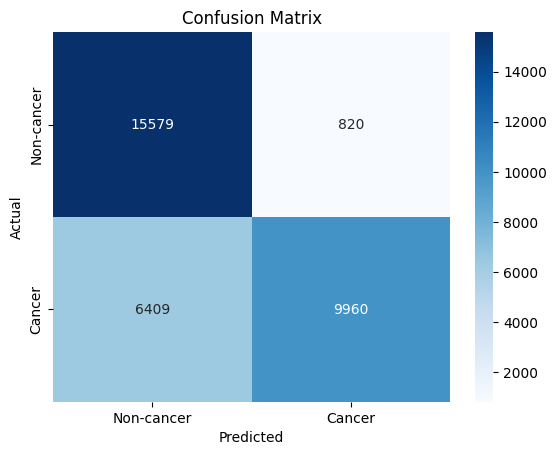

In [ ]:
# I acknowledge the use of generative AI in generating this code block
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = model(images)
            probs = F.sigmoid(outputs)  # Convert to probabilities
            preds = (probs > 0.5).float()  # Convert probabilities to binary predictions

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    # Display metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancer', 'Cancer'], yticklabels=['Non-cancer', 'Cancer'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(model, val_loader)

##Evaluate Performance

This cell evaluates the performance of the model by loading the relevant checkpoint and running the evaluate_model method. The relevant part should be uncommented depending on which model is being evaluated.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-4-f30d5543501d>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = float(self.y[idx])


Accuracy: 0.8067
Precision: 0.9268
Recall: 0.6655
F1 Score: 0.7747
AUC: 0.9113


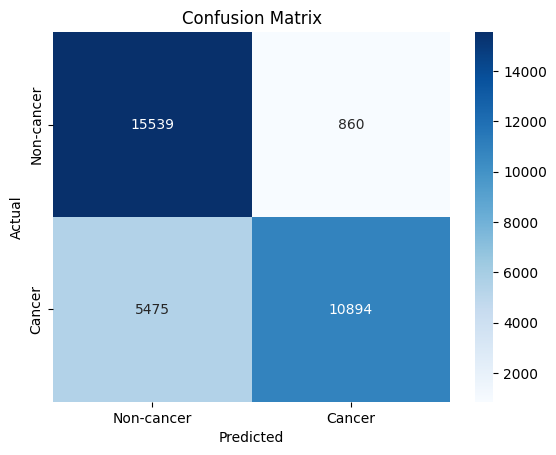

In [ ]:
# CNN
# model = SimpleCnn().to(device)

# DenseNet
model = models.densenet121(pretrained=False)
model.classifier = nn.Linear(model.classifier.in_features, 1).to(device)
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.5),
#     nn.Linear(model.classifier.in_features, 1)
# )
model.to(device)

# ResNet
# model = models.resnet34(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 1)
# model.fc = nn.Sequential(
#     nn.Dropout(p=0.5),
#     nn.Linear(model.fc.in_features, 1)
# )
# model.to(device)

# Load the model from epoch 15
checkpoint = torch.load(f"{base_filepath}/densenetnpt_experiment1_15.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

evaluate_model(model, val_loader)